In [130]:
!pwd

/Users/nico/panoseti/panoseti-software/anomaly-detection


In [131]:
%load_ext autoreload
%autoreload 2

import sys, os
import logging, typing
from torchvision import transforms

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

import torch
from tqdm import tqdm

sys.path.append('../util')
import panoseti_file_interfaces as pfi
import pff
from vae_model import *
from ph_dataset import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
def show_dataset_sample(dataset, nrows=5, ncols=15, cmap='magma', log_cbar=False):
    """Preview images from the dataset."""
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols, nrows))
    # f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_dataset.get_ph_data(idx)['img']
    if log_cbar:
        canvas = ph_dataset.norm(canvas)
        img_plt = plt.imshow(canvas, cmap=cmap)
        # format cbar
        cbar = plt.colorbar(img_plt, fraction=0.027, pad=0.025)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(colorbar_formatter))
        plt.title("Log-Normalized Real Pulse Height Images")
    else:
        canvas = canvas
        img_plt = plt.imshow(canvas, cmap=cmap)
        # format cbar
        cbar = plt.colorbar(img_plt, fraction=0.027, pad=0.025)
        plt.title("Real Pulse Height Images")
    plt.show(f)

In [148]:
ph_dataset_config = {
    "max_ph_frames": 10_000,
    "observing_runs": [
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
    ]
}

In [149]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ConvertImageDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)
ph_dataset.reset_ph_generator()

Computing PH baselines for obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13083.84frames/s]


Computing PH baselines for obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13182.42frames/s]


Computing PH baselines for obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13403.09frames/s]


Computing PH baselines for obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13360.97frames/s]


Computing PH baselines for obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13414.91frames/s]


Computing PH baselines for obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd


100%|████████████████████████████████| 9999/9999 [00:00<00:00, 13520.42frames/s]


Computing PH image statistics


100%|████████████████████████████| 10000/10000 [00:02<00:00, 4389.25ph_frames/s]


{'mean': array(-0.4867387, dtype=float32), 'median': array(-0.3956014, dtype=float32), 'std': array(1.3632908, dtype=float32), 'min': array(-7.30291, dtype=float32), 'max': array(73.93799, dtype=float32), 'q9995': tensor(17.5362)}


In [150]:
ph_dataset.obs_runs

[{'ori': <panoseti_file_interfaces.ObservingRunInterface at 0x31b6de550>,
  'frame_gen_counter': 558,
  'dataset_module_ids': [254, 1, 3],
  'module_meta': {254: {'ph_frame_generator': None,
    'ph_baseline': 77,
    'ph_outlier_cutoff': 64535,
    'ph_median': array([[77. , 77. , 77. , 77. , 77. , 77. , 77. , 77. , 77. , 77. , 77. ,
            77. , 65. , 73. , 77. , 77. ],
           [75. , 77. , 77. , 77. , 74. , 51. , 75. , 63. , 61. , 60. , 77. ,
            74. , 69. , 73. , 66.5, 70. ],
           [69. , 63. , 73. , 65. , 59. , 77. , 76. , 75. , 72. , 70. , 73. ,
            73. , 72. , 55. , 65. , 75. ],
           [65. , 66. , 65. , 21. , 71. , 66.5, 68. , 71. , 70. , 76. , 69. ,
            67. , 17. , 49. , 69. , 76. ],
           [70. , 69. , 62. , 74. , 74. , 70. , 58. , 69. , 73. , 77. , 47. ,
            65. , 60. , 49.5, 72. , 73. ],
           [48. , 71. , 66. , 77. , 70. , 63. , 70. , 66. , 66. , 66. , 68. ,
            77. , 65. , 63. , 77. , 65. ],
           [77.

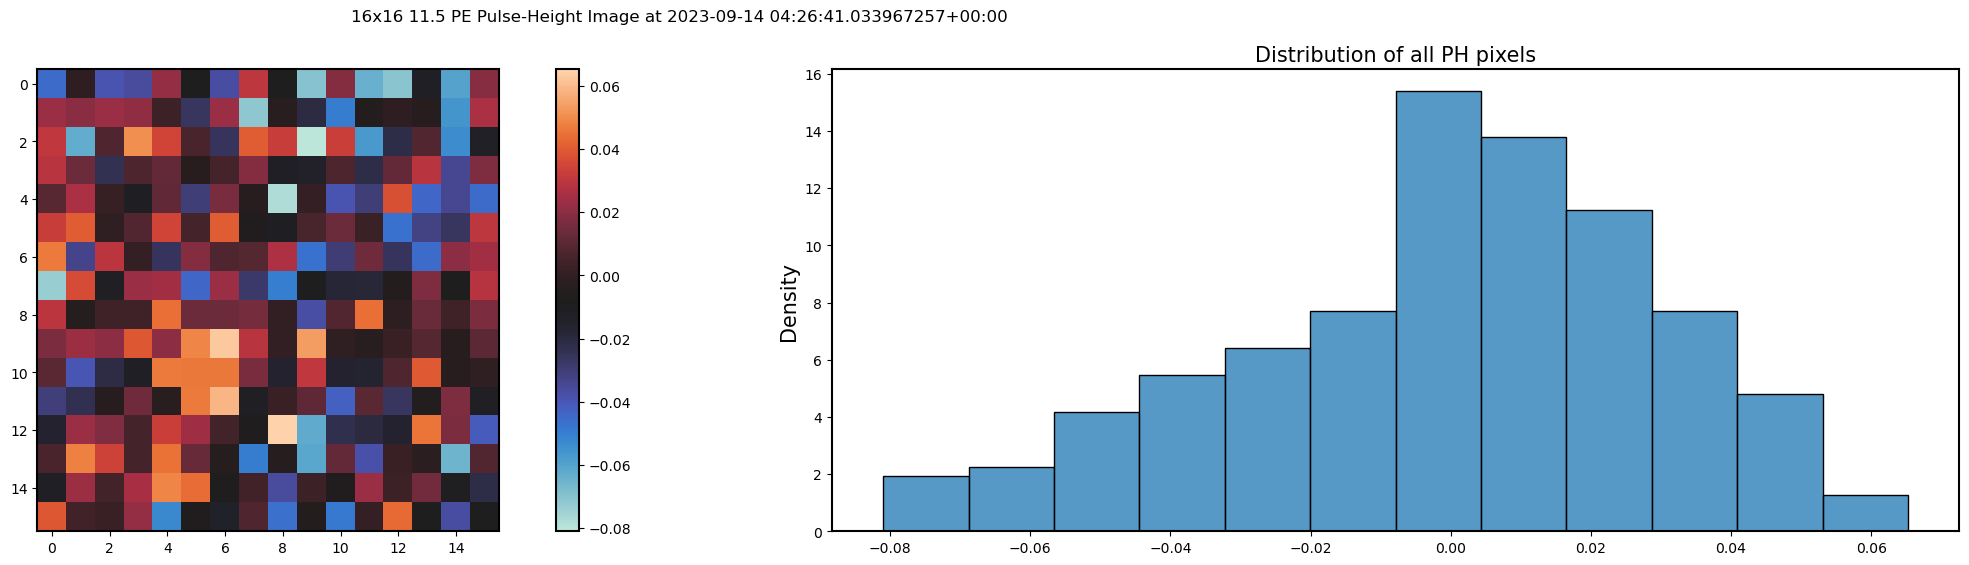

In [151]:
# PH data EDA: visualize PH image and the distribution of pixel values.
# ph_dataset.reset_ph_generator()
ph_data = ph_dataset.get_ph_data(8)

assert ph_data['img'] is not None
f, axs = plt.subplots(1, 2, figsize=(8 * 4, 6))
ph_dataset.plot_ph_img(ph_data['img'], ph_data['meta'], ax=axs[0])
ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[1], upper=None)
# ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[2], upper=False)
# ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[3], upper=True)
f.suptitle(f"16x16 11.5 PE Pulse-Height Image at {ph_data['meta']['unix_timestamp']}")
plt.show()

In [152]:
ph_data['meta']

{'quabo_num': 1,
 'pkt_num': 31030,
 'pkt_tai': 934,
 'pkt_nsec': 33967255,
 'tv_sec': 1694665601,
 'tv_usec': 36757,
 'wr_timestamp (s)': Decimal('1694665601.033967255'),
 'unix_timestamp': Timestamp('2023-09-14 04:26:41.033967257+0000', tz='UTC')}

In [153]:
ph_dataset.EFFECTIVE_MAX_VAL

4095.9375

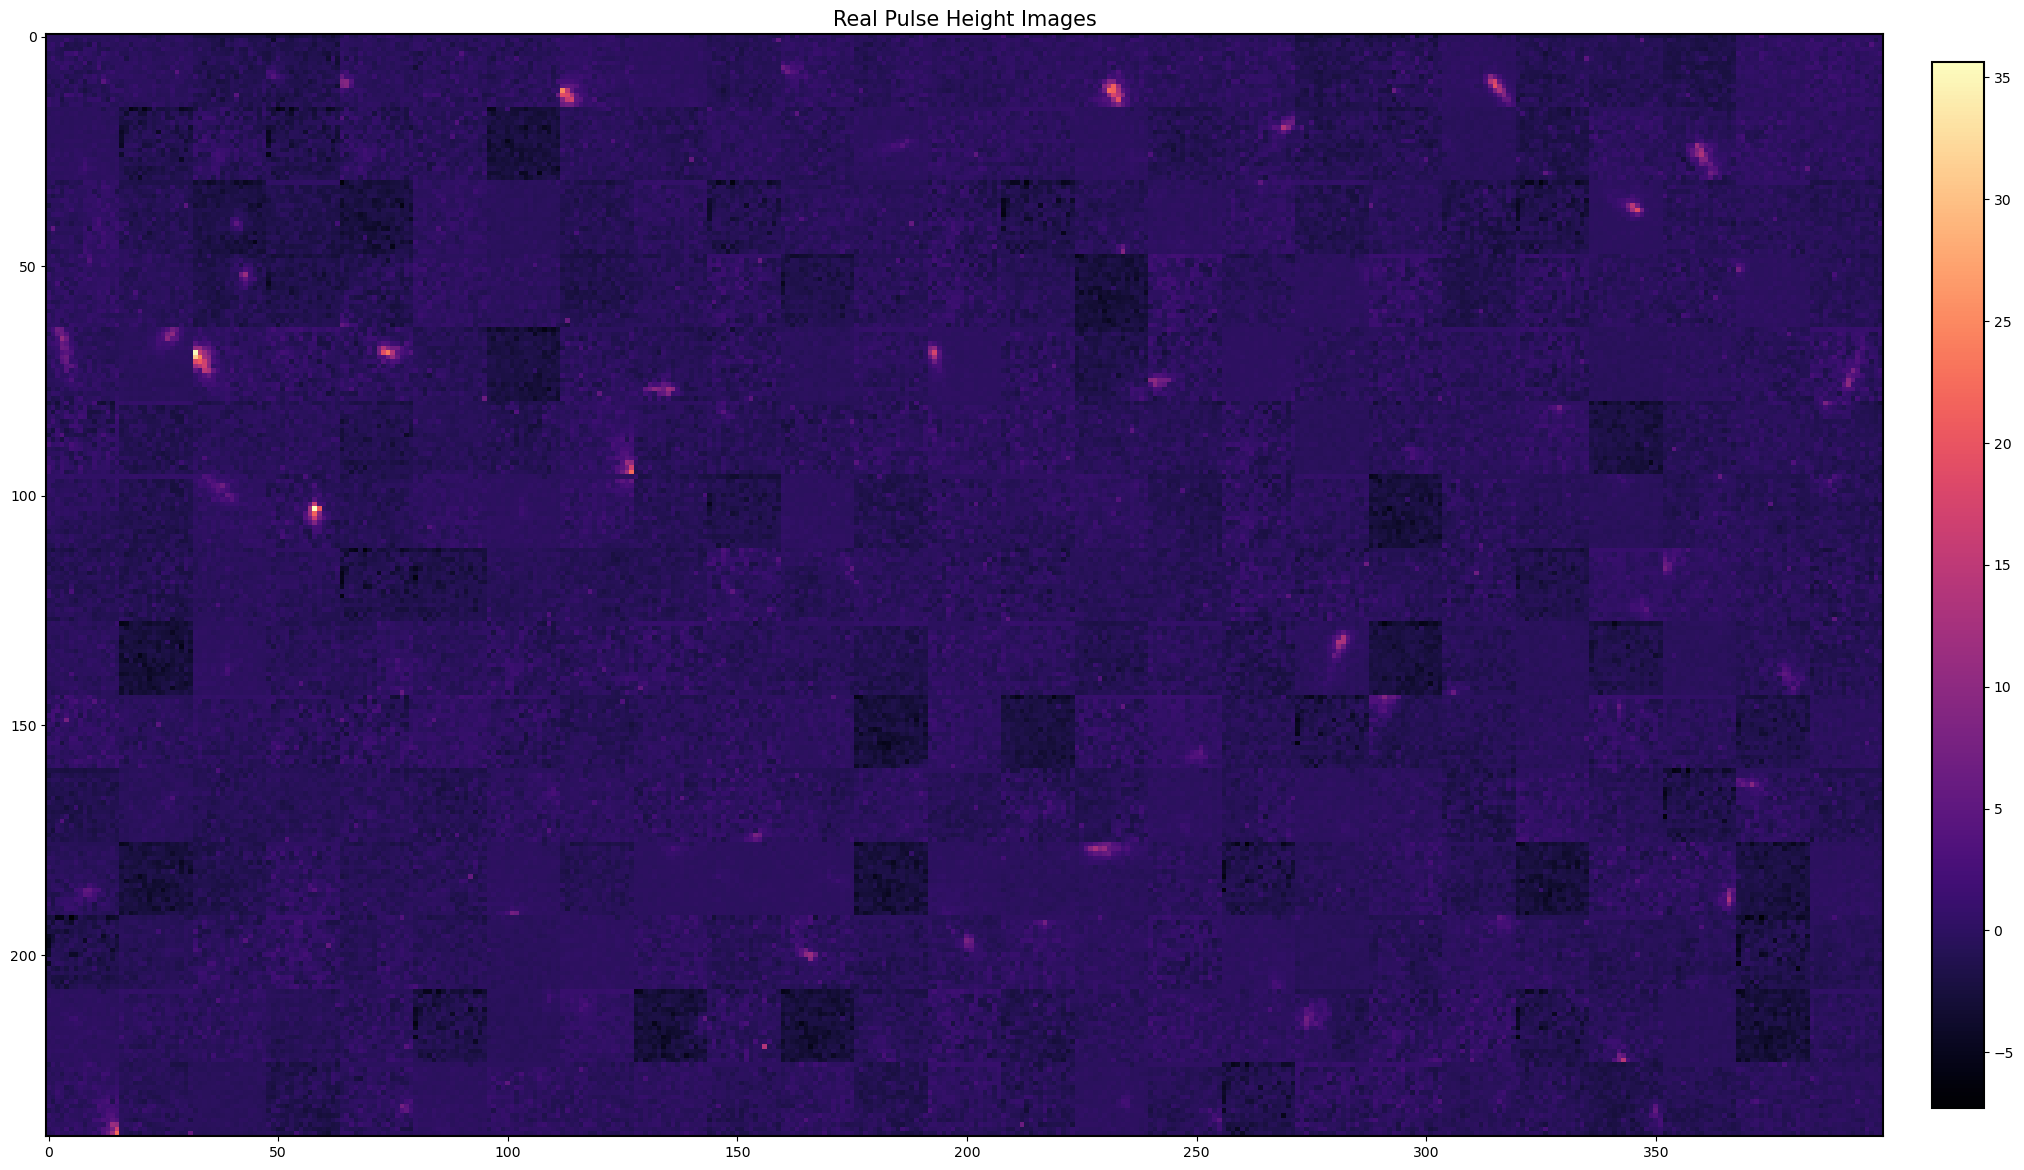

In [154]:
show_dataset_sample(ph_dataset, nrows=15, ncols=25)